In [137]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Keras neural network model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import to_categorical, plot_model
from keras import optimizers, regularizers, initializers
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, BatchNormalization

# Scikit-sklearn preprocessing modules
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,\
                            classification_report, recall_score

# Matplotlib and plotly modules
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker

In [2]:
# latex parameter
font = {
    'family': 'serif', 
    'serif': ['Computer Modern Roman'],
    'weight' : 'regular',
    'size'   : 14
    }

plt.rc('font', **font)
plt.rc('text', usetex=True)

In [3]:
df_total = pd.read_csv("data/total_300.csv")

In [4]:
df_total.columns

Index(['velocity:0', 'velocity:1', 'force:0', 'force:1',
       'total displacement:0', 'total displacement:1', 'temperature',
       'temp_power', 'temp_pressure', 'temp_density', 'node number',
       'plastic strain', 'plastic strain-rate', 'strain-rate II log10',
       'strain-rate XX', 'elastic_strain XX', 'strain-rate ZZ',
       'elastic_strain ZZ', 'strain-rate XZ', 'elastic_strain XZ', 'strain I',
       'strain II', 'strain XX', 'strain ZZ', 'strain XZ', 'stress I',
       'stress II', 'stress XX', 'stress ZZ', 'stress XZ', 'density',
       'thermal_stress', 'energy_total_vol_dev', 'energy_volumetric',
       'energy_deviatoric', 'energy_thermal', 'energy_elastic', 'coordinate:0',
       'coordinate:1'],
      dtype='object')

In [5]:
df_total = df_total.drop_duplicates()

In [6]:
threshold = 0.15
df_total['plastic strain'] = np.where(df_total['plastic strain'] > threshold, 1,0)

In [76]:
label_count = df_total.groupby(df_total['plastic strain'], as_index = False).count()

In [79]:
label_count.head()

,plastic strain,velocity:0,velocity:1,force:0,force:1,total displacement:0,total displacement:1,temperature,temp_power,temp_pressure,...,stress XZ,density,thermal_stress,energy_total_vol_dev,energy_volumetric,energy_deviatoric,energy_thermal,energy_elastic,coordinate:0,coordinate:1
0,0,824099,824099,824099,824099,824099,824099,824099,824099,824099,...,824099,824099,824099,824099,824099,824099,824099,824099,824099,824099
1,1,784160,784160,784160,784160,784160,784160,784160,784160,784160,...,784160,784160,784160,784160,784160,784160,784160,784160,784160,784160


In [80]:
class_name = list(label_count['plastic strain'])
count = list(label_count['velocity:0'])

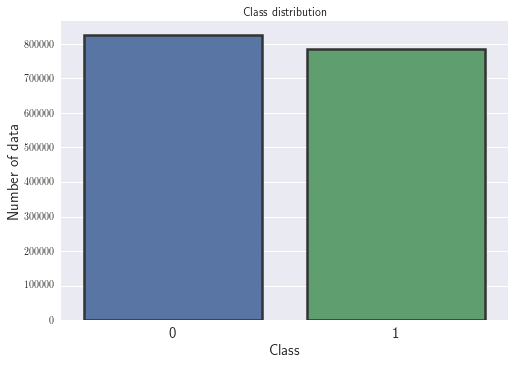

In [83]:
index = np.arange(len(class_name))
# plt.bar(class_name, count)
sns.barplot(x=class_name, y=count, linewidth=2.5, errcolor=".2", edgecolor=".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of data', fontsize=15)
plt.xticks(index, class_name, fontsize=15)
plt.title('Class distribution')
plt.show()

In [84]:
feature_cols = ['velocity:0', 'velocity:1', 'temperature', 'stress XX', 'stress ZZ', 'stress XZ', 'density']

dropped_cols = ['plastic strain', 'plastic strain-rate', 'strain-rate II log10', 'strain-rate XX',
       'elastic_strain XX', 'strain-rate ZZ', 'elastic_strain ZZ',
       'strain-rate XZ', 'elastic_strain XZ', 'strain I', 'strain II',
       'strain XX', 'strain ZZ', 'strain XZ', 'coordinate:0', 'coordinate:1', 'force:0', 'force:1', 
       'total displacement:0', 'total displacement:1', 'stress I', 'stress II', 'energy_volumetric', 
       'energy_deviatoric','energy_thermal', 'energy_elastic', 'thermal_stress',
       'energy_total_vol_dev', 'temp_power', 'temp_pressure', 'temp_density', 'node number']

In [85]:
def scale_feature(features):    
    mms = StandardScaler()
    scaled_features = mms.fit_transform(features)
    return scaled_features, mms

## Neural network model

In [174]:
class build_neural_network:
    
    def __init__(self, model_name, xtrain, ytrain, xval, yval):
        self.model_name = model_name
        self.xtrain = xtrain
        self.ytrain = to_categorical(ytrain)
        self.xval = xval
        self.yval = to_categorical(yval)
        self.input_shape = np.shape(xtrain)[1]
        self.output_shape = np.shape(self.ytrain)[1]
        self.model = None
        self.ypred = None
        self.weight_path = "./weights/"
            
    def get_model_weights(self):
        return self.model.get_weights()

    def create_model(self):
        self.model = Sequential()
        self.model.add(Dense(self.input_shape, 
                             kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed = 2018), 
                             activation = 'relu', name='layer_1',
                             input_shape = (self.input_shape,)))
        
        self.model.add(Dense(12, activation = 'relu', name='layer_2'))
            
        self.model.add(Dense(self.output_shape, activation="softmax", name='Output_layer'))
        self.model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
        self.model.summary()
        
    
    def train_model(self, training_epochs):
        self.create_model()
        
        filepath = self.weight_path + str(self.model_name) + '.hdf5'
        
        if not os.path.exists(self.weight_path):
            os.makedirs(self.weight_path)
        
        checkpoint = ModelCheckpoint(filepath, verbose=0, period = training_epochs)
        tensorboard = TensorBoard(log_dir="logs/", histogram_freq=1, write_graph=True)

        self.model.fit(self.xtrain, self.ytrain, batch_size = 64, epochs = training_epochs, 
        callbacks = [tensorboard, checkpoint], validation_data=(self.xval, self.yval))
        
        self.save_model()
        return self.model
        
    def save_model(self):
        file_name = str(self.weight_path) + str(self.model_name)
        self.model.save(file_name)
    
    def predict(self, xtest):
        self.ypred = self.model.predict(xtest)


In [175]:
Y = df_total['plastic strain']
X, mms = scale_feature(df_total[feature_cols])
xtrain, xval, ytrain, yval = train_test_split(X, Y, test_size=0.33, random_state=2018)

In [176]:
model_name = "Total"
model = build_neural_network(model_name, xtrain[0:500, :], ytrain[0:500], xval[1000:1500, :], yval[1000:1500])
model.train_model(10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 7)                 56        
_________________________________________________________________
layer_2 (Dense)              (None, 12)                96        
_________________________________________________________________
Output_layer (Dense)         (None, 2)                 26        
Total params: 178
Trainable params: 178
Non-trainable params: 0
_________________________________________________________________
Train on 500 samples, validate on 500 samples
INFO:tensorflow:Summary name layer_1_24/kernel:0 is illegal; using layer_1_24/kernel_0 instead.
INFO:tensorflow:Summary name layer_1_24/bias:0 is illegal; using layer_1_24/bias_0 instead.
INFO:tensorflow:Summary name layer_2_22/kernel:0 is illegal; using layer_2_22/kernel_0 instead.
INFO:tensorflow:Summary name layer_2_22/bias:0 is illegal; using layer_2_22/bi

InvalidArgumentError: Shape [-1,7] has negative dimensions
	 [[Node: layer_1_input_14 = Placeholder[dtype=DT_FLOAT, shape=[?,7], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'layer_1_input_14', defined at:
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-151-d711ef46669d>", line 3, in <module>
    model_history = model.train_model(10)
  File "<ipython-input-144-73e0d082f7f7>", line 33, in train_model
    self.create_model()
  File "<ipython-input-144-73e0d082f7f7>", line 23, in create_model
    input_shape = (self.input_shape,)))
  File "/usr/local/lib/python3.6/site-packages/keras/models.py", line 439, in add
    dtype=layer.dtype, name=layer.name + '_input')
  File "/usr/local/lib/python3.6/site-packages/keras/engine/topology.py", line 1426, in Input
    input_tensor=tensor)
  File "/usr/local/lib/python3.6/site-packages/keras/legacy/interfaces.py", line 88, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/keras/engine/topology.py", line 1337, in __init__
    name=self.name)
  File "/usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 431, in placeholder
    x = tf.placeholder(dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1530, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1954, in _placeholder
    name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Shape [-1,7] has negative dimensions
	 [[Node: layer_1_input_14 = Placeholder[dtype=DT_FLOAT, shape=[?,7], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [73]:
val = 350
file_name = "new_data/totoal."+ str(val) +".csv"
df_test = pd.read_csv(file_name)
df_test = df_test.drop_duplicates()
df_test['plastic strain'] = np.where(df_test['plastic strain'] > threshold, 1,0)
xtest = df_test[feature_cols]
ytest = df_test['plastic strain']
xtest = mms.fit_transform(xtest)

In [124]:
ypred = model.predict(xtest)

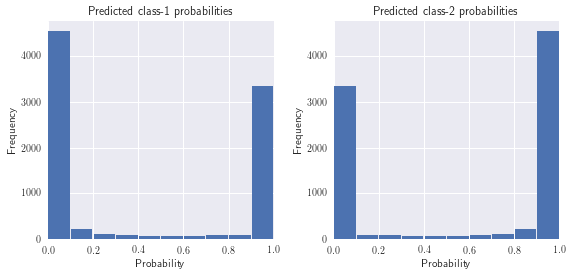

In [126]:
# histogram of predicted probabilities
plt.figure(figsize=(12, 4))
nclasses = 2
for i in range(nclasses):
    
    plt.subplot(1, 3, i+1)
    plt.hist(ypred[:, i], bins=10, histtype='bar', rwidth=0.95)
    plt.xlim(0,1)
    plt.title('Predicted class-{} probabilities'.format(i+1))
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [127]:
def repredict(ypred):
    length = (ypred.shape)[0]
    newpred = []
    for i in range(length):
        if ypred[i, 1] >= 0.75:
            newpred.append(1)
        else:
            newpred.append(0)
    return newpred

In [133]:
newpred_test = repredict(ypred)

In [134]:
print('1. The F-1 score of the model {}\n'.format(f1_score(ytest, newpred_train, average='macro')))
print('2. The recall score of the model {}\n'.format(recall_score(ytest, newpred_train, average='macro')))
print('3. Classification report \n {} \n'.format(classification_report(ytest, newpred_train)))
print('4. Confusion matrix \n {} \n'.format(confusion_matrix(ytest, newpred_train)))

1. The F-1 score of the model 0.8831392120926289

2. The recall score of the model 0.9106764746575173

3. Classification report 
              precision    recall  f1-score   support

          0       0.76      0.98      0.86      3003
          1       0.99      0.84      0.91      5697

avg / total       0.91      0.89      0.89      8700
 

4. Confusion matrix 
 [[2952   51]
 [ 921 4776]] 



## Test data preparation

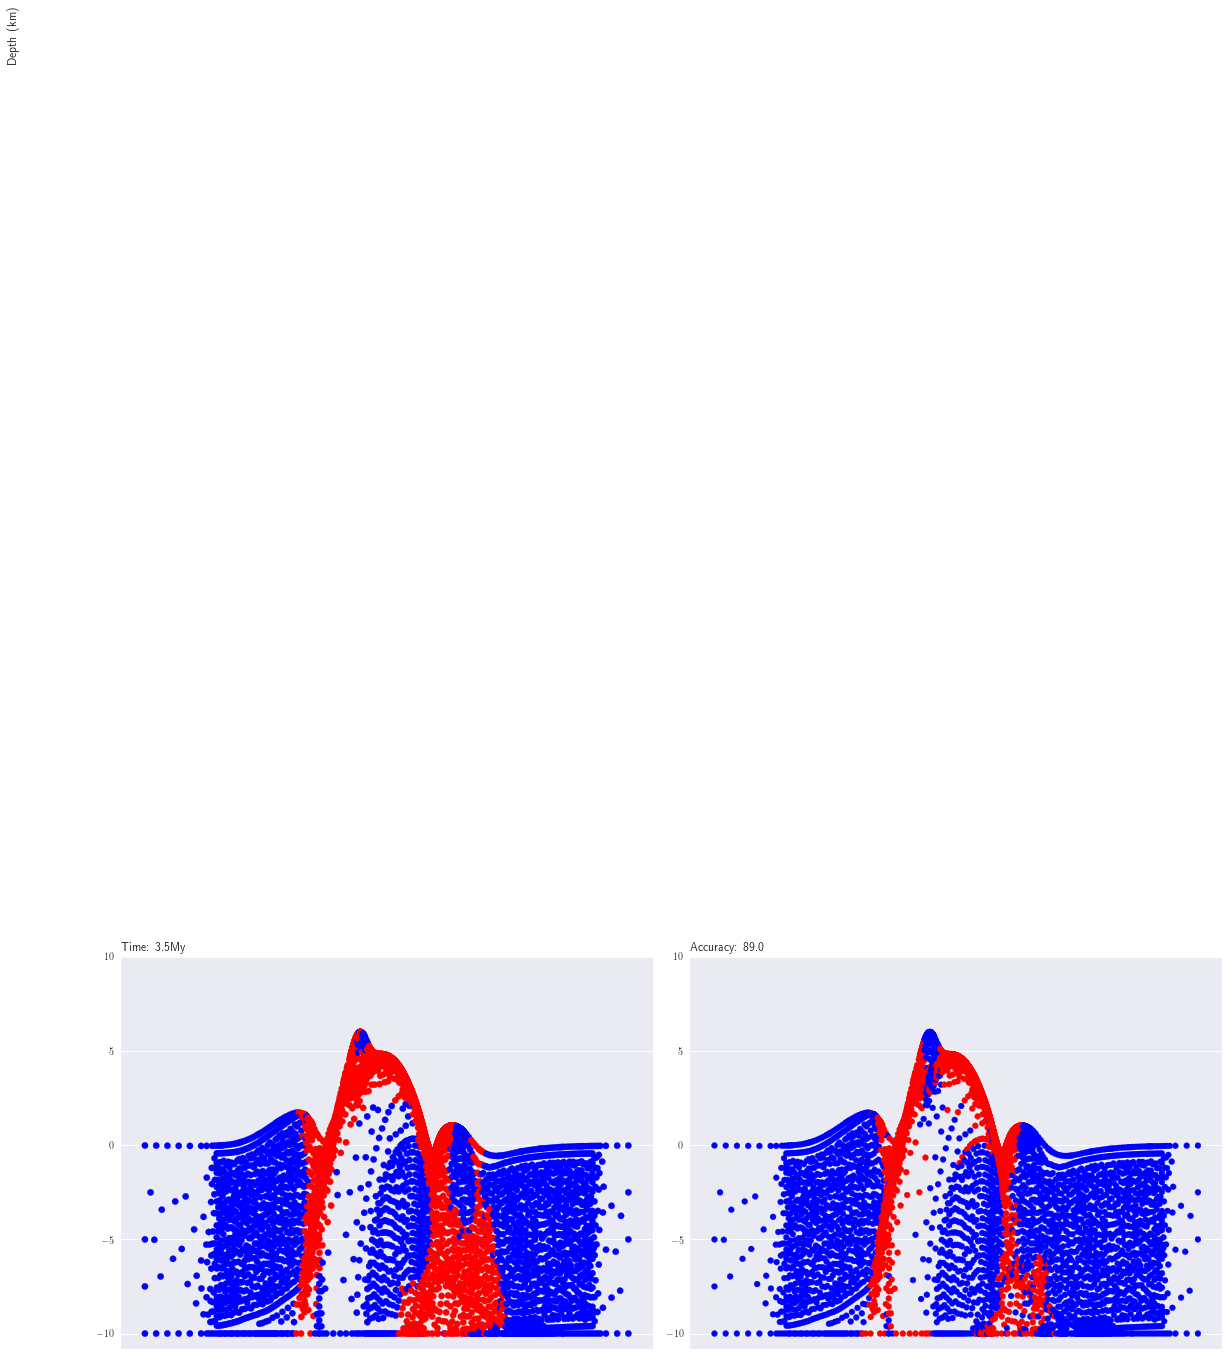

In [135]:
times = [350]
fig = plt.figure(figsize = (16,6))

for i, val  in enumerate(times):
    
#     file_name = "new_data/totoal."+ str(val) +".csv"
#     df_test = pd.read_csv(file_name)
#     df_test = df_test.drop_duplicates()
#     threshold = 0.15
#     df_test['plastic strain'] = np.where(df_test['plastic strain'] > threshold, 1,0)
#     xtest = df_test[feature_cols]
#     ytest = df_test['plastic strain']
#     scale = mms[0]
#     xtest = scale.fit_transform(xtest)
#     ypred = np.argmax(deviatoric.model.predict(xtest), axis = 1)
    acc = accuracy_score(ytest, newpred_test)
    
    ## Plot figure
    plt.subplot(1,2, (i+(i+1)))
    plt.scatter(x = df_test['coordinate:0']/1e3, y= df_test['coordinate:1']/1e3, 
                c = df_test['plastic strain'], vmin=0, vmax=1, s = 40 , cmap='bwr')
    plt.title('Time: ' + str(val/100.0)+'My', loc='left')
    plt.yticks([10, 5, 0, -5, -10])
    if (i+2) == 5:
        plt.xticks([-25, 0, 25, 50, 75, 100, 125])
        plt.xlabel('Distance (km)')
    else:
        plt.xticks([])
        
    
    plt.subplot(1,2,(i+(i+2)))
    plt.scatter(df_test['coordinate:0']/1e3, y= df_test['coordinate:1']/1e3,\
                c = newpred_test,\
                vmin = 0, vmax = 1, s = 35, cmap = 'bwr')
    
    plt.title('Accuracy: '+ str(round(acc, 2)*100) + '%', loc='left')
    plt.yticks([10, 5, 0, -5, -10])
    
    if (i+2) == 5:
        plt.xticks([-25, 0, 25, 50, 75, 100, 125])
        plt.xlabel('Distance (km)')
    else:
        plt.xticks([])
        
plt.text(-215, 60, 'Depth (km)', rotation=90)
plt.tight_layout()
fig.savefig('original_vs_predicted.png')
plt.show()

In [20]:
ytest = df_test['plastic strain']
print('Accuracy: {}\n'.format(accuracy_score(ytest, ypred)))
print('Classification report: \n {}\n'.format(classification_report(ytest, ypred)))
print('Confusion matrix: \n{}'.format(confusion_matrix(ytest, ypred)))

Accuracy: 0.9117996201329535

Classification report: 
              precision    recall  f1-score   support

          0       0.81      0.98      0.89      2963
          1       0.99      0.88      0.93      5461

avg / total       0.92      0.91      0.91      8424


Confusion matrix: 
[[2897   66]
 [ 677 4784]]


## Load model 

In [4]:
model = load_model('./weights/total_200.hdf5')

## Add application to real world

In [ ]:
app_feature_cols = ['velocity:0', 'velocity:1', 'temperature', 'stress XX', 'stress ZZ', 'stress XZ', 'density']